# Practical 03 - RRT Algorithm

Note: CoLab is not supported for this week. For the online version, please visit https://mybinder.org/v2/gh/tianleimin/ECE4078_Practical_2021/main and proceed as if running locally. **Remember to download a copy of the notebook when you are done if running online. Otherwise, you will lose the notebook once you close the tab.**

In [1]:
%matplotlib notebook

import math
import random
import os
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import time

# Import dependencies and set random seed
seed_value = int(time.time())#5
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)


from helper_james import *

global ani

[array([-1.2, -1.2]), array([-1.2, -1.2]), array([-1.00810599, -1.14363787]), array([-0.90549027, -0.97196955]), array([-0.70556964, -0.97760352]), array([-0.54540235, -0.8578269 ]), array([-0.61915071, -0.67192053]), array([-0.60076807, -0.47276712]), array([-0.63865169, -0.31731671]), array([-0.83371646, -0.27316091]), array([-0.82113791, -0.19887984]), array([-0.74715524,  0.49719959]), array([-0.74715524,  0.49719959]), array([-0.93615745,  0.56260727]), array([-1.12296897,  0.4911828 ]), array([-1.20900833,  0.60020298]), array([-1.17747917,  1.29949255]), array([-1.17747917,  1.29949255]), array([-0.99052788,  1.22843475]), array([-1.04180089,  1.03511874]), array([-0.87648897,  0.9225489 ]), array([-0.71210638,  0.80862627]), array([-0.56077617,  0.67786249]), array([-0.36135319,  0.69304388]), array([-0.172491  ,  0.75885478]), array([0.01443198, 0.68772251]), array([0.16733373, 0.81664518]), array([0.2761235, 0.6488215]), array([0.46749988, 0.59072607]), array([0.64863241, 0.5

<IPython.core.display.Javascript object>


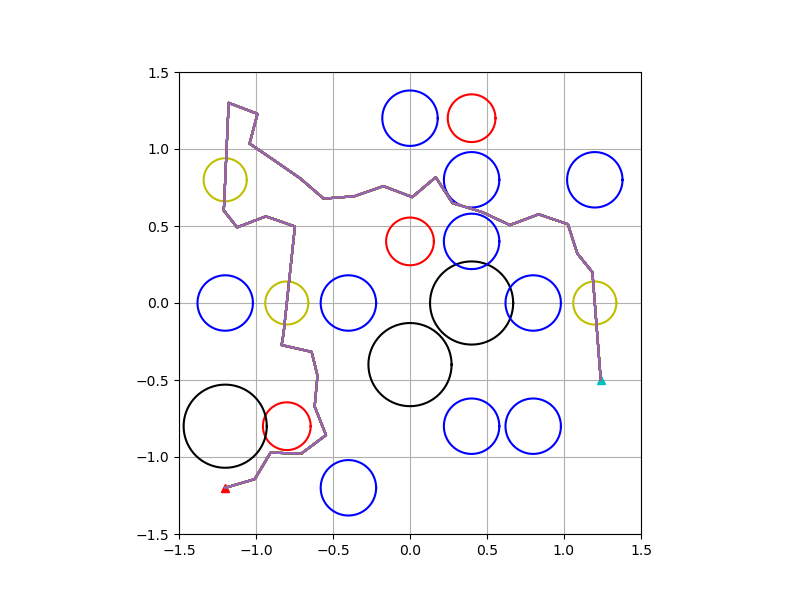

In [23]:
# build obstacle list from map file

gt_dict = {
    "lemon_2": {"y": 0.8, "x": -1.2}, 
    "lemon_1": {"y": 0.0, "x": -0.8}, 
    "lemon_0": {"y": 0.0, "x": 1.2}, 
    "aruco4_0": {"y": -0.8, "x": 0.8}, 
    "aruco3_0": {"y": 0.0, "x": 0.8}, 
    "aruco1_0": {"y": 0.0, "x": -1.2}, 
    "aruco8_0": {"y": -1.2, "x": -0.4}, 
    "apple_0": {"y": 1.2, "x": 0.4}, 
    "apple_1": {"y": -0.8, "x": -0.8}, 
    "aruco5_0": {"y": 0.8, "x": 0.4}, 
    "aruco9_0": {"y": 0.0, "x": -0.4}, 
    "apple_2": {"y": 0.4, "x": 0.0}, 
    "aruco6_0": {"y": -0.8, "x": 0.4}, 
    "person_2": {"y": -0.4, "x": 0.0}, 
    "person_0": {"y": -0.8, "x": -1.2}, 
    "person_1": {"y": 0.0, "x": 0.4}, 
    "aruco7_0": {"y": 1.2, "x": 0.0},
    "aruco10_0": {"y": 0.4, "x": 0.4}, 
    "aruco2_0": {"y": 0.8, "x": 1.2}
}
  
apple_gt, lemon_gt, person_gt, marker_gt = [], [], [], []

    # remove unique id of targets of the same type 
for key in gt_dict:
    if key.startswith('apple'):
        apple_id = key.split('_')[1]
        apple_gt.append(np.array(list(gt_dict[key].values())[::-1] + [apple_id], dtype=float))
    elif key.startswith('lemon'):
        lemon_id = key.split('_')[1]
        lemon_gt.append(np.array(list(gt_dict[key].values())[::-1] + [lemon_id], dtype=float))
    elif key.startswith('person'):
        person_id = key.split('_')[1]
        person_gt.append(np.array(list(gt_dict[key].values())[::-1] + [person_id], dtype=float))
    elif key.startswith('aruco'):
        aruco_id = key.split('_')[0].split('aruco')[1]
        marker_gt.append(np.array(list(gt_dict[key].values())[::-1] + [aruco_id], dtype=float))

r_true_apple = 0.075
r_true_lemon = 0.06
r_true_person = 0.19
r_true_marker = 0.1


scale = 0.08

r_true_apple += scale
r_true_lemon += scale
r_true_person += scale
r_true_marker += scale

all_obstacles = []
for entry in apple_gt:
    all_obstacles.append(CircleT(entry[0], entry[1], r_true_apple, 0))

for entry in lemon_gt:
    all_obstacles.append(CircleT(entry[0], entry[1], r_true_lemon, 1))
    
for entry in person_gt:
    all_obstacles.append(CircleT(entry[0], entry[1], r_true_person, 2))
    
for entry in marker_gt:
    all_obstacles.append(CircleT(entry[0], entry[1], r_true_marker, 3))


## obstacle list complete, we now want to generate pairings of people and apples, and mark which lemons need to be moved

required_distance = 0.5
goal_error = 0.05

## dont move apples that are already in place, find these pairs

#people_done = []
#apples_done = []
#pairs = []


#for person_idx, person in enumerate(person_gt):
#    for apple_idx, apple in enumerate(apple_gt):
#        if apple[0] in apples_done:
#            continue
#        elif np.hypot(apple[0] - person[0], apple[1] - person[1]) < (required_distance - goal_error):
#            #if this is the case, an apple is within range of a person, including some consideration of error
#            apples_done.append(apple[0])
#            people_done.append(person[0])
#            pairs.append((person, apple))
#            
#people_not_done = [n for n in person_gt if n[0] not in people_done]
#apples_not_done = [n for n in apple_gt if n[0] not in apples_done]

#print(people_not_done, "\n", apples_not_done)

# assemble all combinations of people and apples who are not matched

#unmatched_pairs = []
#unmatched_person_ids = [n for n in person]

#for person in people_not_done:
#    for apple in apples_not_done:
#        unmatched_pairs.append((person, apple, np.hypot(apple[0] - person[0], apple[1] - person[1])))

#print(unmatched_pairs)

# pick combination of unmatched pairs which minimises travel distance


#list1 = ["a", "b", "c"]
#list2 = [1, 2]

#all_combinations = [list(zip(each_permutation, list2)) for each_permutation in itertools.permutations(list1, len(list2))]
#print(all_combinations)



## something new.

def ignore_obs(obs_list, ignore):
    obs_cpy = obs_list[:]
    for i, obs in enumerate(obs_list):
        if all(obs.center == ignore[0:2]):
            obs_cpy.remove(obs)
    return obs_cpy



def collision_between_points(p1, p2, obs_list, radius, samples=50):
    x_vals = np.linspace(p1[0], p2[0], samples)
    y_vals = np.linspace(p1[1], p2[1], samples)
    
    points = np.column_stack((x_vals, y_vals))

    collision = False
    for obs in obs_list:
        for point in points:
            if np.linalg.norm(point - obs.center) < (obs.radius + radius):
                collision = True

    
    return collision


def move_apple_to_person(apple, person):
    return [(apple[2], apple[1]), (person[2], person[1])]


def find_collinear_behind(B, A, offset):
    
    if np.all(np.isclose(B, A)):
        raise ValueError
    
    AB = B - A
    # find k s.t. k * abs(AB) = abs(AB) + offset
    abs_AB = np.linalg.norm(AB)

    k = (abs_AB + offset)/abs_AB

    BA = A-B
    
    k_BA = k*BA
    
    return B + k_BA


def push_bad_lemon_away(lemon, obs, robot_collinear_space = 0.1):
    # need to determine a path that:
    # - has a straight path with no obstacles
    
    # generate a bunch of potential straight line paths 
    
    # need a path thats wide enough for 4cm radius lemon
    pushed_lemon_r = 0.1
    
    potential_traj = []
    for angle in np.linspace(0, 2*np.pi, 30):
        new_point = 3*np.array([np.cos(angle), np.sin(angle)])
        if not collision_between_points(lemon[0:2], new_point, ignore_obs(obs, lemon), pushed_lemon_r):
            potential_traj.append(new_point)
    
    # - can be pathed in behind
    #print(f"{np.array(potential_traj)}")
    successful = []
    bad = False
    # go some distance behind the lemon while collinear with the goal point, check if this collides anywhere
    for candidate in potential_traj:
        potential_point = find_collinear_behind(candidate, lemon[0:2], 0.2)
        bad = False
        for ob in ignore_obs(obs, lemon):
            if np.linalg.norm(ob.center - potential_point) < robot_collinear_space + ob.radius:
                bad = True
                break
        if not bad:
            successful.append(potential_point)
    
    #print(f"{np.array(successful)}")
    
    if len(successful) == 0:
        raise ValueError("failed to push lemon ", lemon[2])
    
    return successful


def compute_seq_length(seq):
    total_len = 0
    for i in range(len(seq)-1):
        total_len += (np.linalg.norm(seq[i]-seq[i+1]))
    return total_len



def push_lemon_x(A, B, dist):
    
    AB = B - A
    # find k s.t. k * abs(AB) = abs(AB) + dist
    abs_AB = np.linalg.norm(AB)

    k = (abs_AB + dist)/abs_AB
    
    k_AB = k*AB
    
    return A + k_AB

    
best_sol = ([], np.inf)


iterations = 20
for i in range(iterations):
    # try a path combination
    #unpaired_apple = [] # list of apples not yet paired
    #unpaired_person = [] # list of people without apple
    bad_lemon = lemon_gt.copy() # list of lemons requiring moving
    
    #done_apple = False
    done_lemon = False
    # build path that pairs people with apples, removes lemons, compute total distance
    
    seq = []
    seq.append(np.array([-1.2, -1.2]))
    
    while True:
        # move apple to person or move lemon away
        #flag = np.random.randint(0,2)
        seq_int = []
 #       print("here")
        #if flag and not done_apple:
        #    if not len(unpaired_person) or not len(unpaired_apple):
        #        done_apple = True
        #    else:
        #        # move apple to person
        #        random.shuffle(unpaired_person)
        #        unpaired_person.pop()
        #    
        #        random.shuffle(unpaired_apple)
        #        unpaired_apple.pop()
            
                # random apple and person, move apple to person
            
        #        seq_int = move_apple_to_person()
            
        if not done_lemon:
            # move random lemon away
            
            if not len(bad_lemon):
                done_lemon = True
            else:
                random.shuffle(bad_lemon)
                the_lemon = bad_lemon.pop()
                
                potential_lemon_push_pos = random.choice(push_bad_lemon_away(the_lemon, all_obstacles)) # just take first one for now
                
 #               print(potential_lemon_push_pos)
                ## RRT to lemon, push straight
#                print("seq", np.array(seq[-1]))
                
                rrt_path = None
                
                rrt_res = RRT(
                    start=seq[-1],
                    goal=potential_lemon_push_pos, 
                    width=1.4, height=1.4, 
                    obstacle_list=all_obstacles, 
                    expand_dis=0.2, path_resolution=0.04,
                    max_points=50
                )
                
                while rrt_path is None:
                    rrt_path = rrt_res.planning()

#                print("aaa")
                
                rrt_path.reverse()
                
                # just push it 0.5m for now
                #print(to_lemon[-1], the_lemon)
                
                dest = push_lemon_x(rrt_path[-1], the_lemon[0:2], 0.5)
                
                
                seq_int = rrt_path + [dest]
        
        #print(done_apple, done_lemon)
        
        if done_lemon: #and done_lemon:
            break
        else:
            seq += seq_int
            #print(np.array(seq))
        
    # done a sequence, compute sequence length

    length = compute_seq_length(seq)
#    print(length)
    
    if length < best_sol[1]:
        best_sol = (seq, length)

print(best_sol[0], np.array(best_sol[1]))

        

def animate_path_x(x, xlim1, ylim1, obs_list):
    path = x
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                         xlim=xlim1, ylim=ylim1)
    ax.grid()

    ax.plot(x[0,0],x[0,1], "^r", lw=5)
    ax.plot(x[-1,0],x[-1,1], "^c", lw=5)

    obs_colour = ["r", "y", "k", "b"]
    
    for obs in obs_list:
        cx, cy = obs.center
        plot_circle(ax, cx, cy, obs.radius, color = obs_colour[obs.tag])
            
    for point in x:
        ax.plot(x[:,0], x[:,1])
    
        

A = np.array([2,0])
B = np.array([0,0])

#print(find_collinear_behind(B, A, 0.3))

#print(push_lemon_x(A, B, 0.5))

# run rrt pathing test
start = [-1, -1]
goal = [1, 1]

#rrt = RRT(start=start, goal=goal, width=1.4, height=1.4, obstacle_list=all_obstacles, expand_dis=0.3 , path_resolution=0.04, max_points=500)

#print(rrt.planning())
ani_path= animate_path_x(np.array(best_sol[0]), (-1.5, 1.5), (-1.5, 1.5), all_obstacles)

lemon = 2


display(HTML("<style>.container { width:100% !important}</style>"))

# 